# Improving Cars as a Proxy for Shoppers

<img width=50% src=pics/parking_lot.jpg /img>
source of image: https://si.wsj.net/public/resources/images/P1-BO440_REPLIC_P_20131218220538.jpg

During my discussions the topic came up more than once, of converting 1 car/shopper into a better estimate, getting a handle on:

$$total shoppers \approx (people/1{car})(n_{cars})$$

### Fundalmental Question
* How can we better estimate the spending power of a car ?

### Let's use another proxy
 * Assume that more people means tendency to higher expenditure
 * Bigger vehicle is a more affluent shopper
 * Bigger vehicles have the ability to transport more or larger items


### How to get vehicle size estimate 
* Corner detection on the cars to get vehicle dimension estimates???
* Some other method the CV team can get working.
 
If the ability for detection is isolated, we fall back to linear relationship:
(dimensions_detected / total_cars)(gross sales) and fit to that line.

### Experiment
* We choose one store with good ability for corner detection.
 * Calculate vehicle dimension estimates
    * by hand if it's faster
 * data set composed only of weekends (expect whole family)
* Obtain gross sales record over 5 years
* Fit sales to car count
 * Try to improve fit using vehicle dimensions as an additional parameter




# Technical Considerations
For simplicity sake:
* I'm only using the length dimension
* Using an image with veritcally aligned cars

## Some vehicle dimensions
* Chevy Tahoe: $518 cm$
* Toyata Celica: $434 cm$

$\Delta{L}=84 cm$

$k_{nyquist}$ for 30 cm camera = 60 cm. 

I estimated the resolution of the satelite image above, by zooming in on a region with cars.
I counted the numebr of pixels that appear to make up a car and figured that the average car is
$\approx 2m$ in width. 

I'll need to do a better estimate:

* research average passenger car dimensions on web
* use both dimension in my eye-ball count
* repeat eye-ball count many times and average

## Will A Corner Detection Routine Even Work?
I don't know...maybe. Below is my naive anaylsis of the feasibility. Boris and Jason can tell us much better.

In [1]:
import sys
sys.path.append("/home/daniel/git/Python2.7/DataScience/notebooks/orbital")

In [2]:
import scipy.ndimage
import matplotlib.pyplot as plt
from scipy import fftpack
import radialProfile
%matplotlib inline

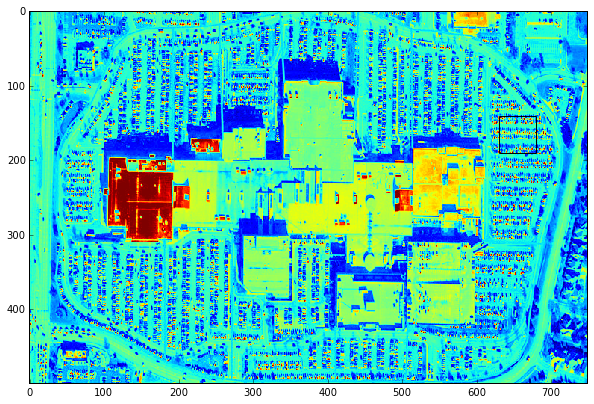

In [49]:
data = scipy.ndimage.imread("pics/parking_lot.jpg", flatten=True)

plt.figure(figsize=(10, 10))
plt.imshow(data, interpolation='nearest', origin='upper', cmap='jet')
plt.hlines(190, 630, 680, 'k')
plt.hlines(140, 630, 680, 'k')
plt.vlines(630, 140, 190, 'k')
plt.vlines(680, 140, 190, 'k')

<matplotlib.colorbar.Colorbar instance at 0x7f04861b8fc8>

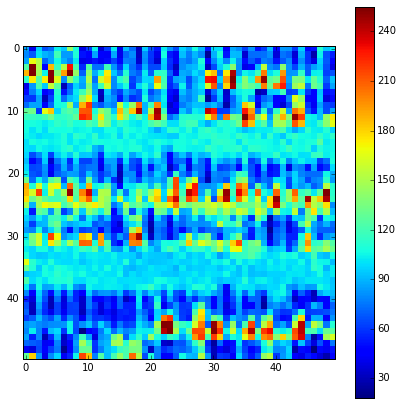

In [66]:
data_sub = data[140:190, 630:680]

plt.figure(figsize=(7, 7))
plt.imshow(data_sub, interpolation='nearest', origin='upper')
plt.colorbar()

In [51]:
def fft2D(data):
    fft = fftpack.fft2(data)
    fft_shift = fftpack.fftshift(fft)
    power2D = np.abs(fft_shift)**2
    power1D = radialProfile.azimuthalAverage(power2D)
    
    return power1D

In [52]:
## k space scale
def k_scale(dim, npts):
    camera_res = 90 # cm           
    max_len = camera_res * dim #cm , size of sub plot
    nyq = 2 * 90 #cm
    range_ = max_len - nyq
    # reverse order
    k = np.flipud(np.arange(nyq, max_len,range_/npts))
    return k

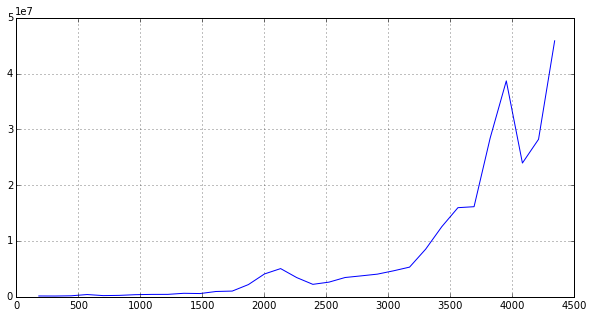

In [73]:
power1D = fft2D(data_sub)
k = k_scale(data_sub.shape[0], power1D.shape[0])
# not sure why k len is one element too long...deal with later
plt.figure(figsize=(10, 5))
plt.plot(k[1:], power1D)
plt.grid()

Try again with an edge filter first.

<matplotlib.colorbar.Colorbar instance at 0x7f0485dcd7e8>

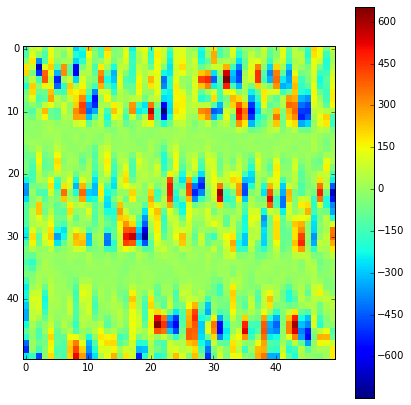

In [71]:
sobel = scipy.ndimage.filters.sobel(data)
sobel_sub = sobel[140:190, 630:680]
sobel_sub[np.isnan(sobel_sub)] = 0
#sobel_sub = np.abs(sobel_sub) # bad idea

plt.figure(figsize=(7, 7))
plt.imshow(sobel_sub, interpolation='nearest', origin='upper')
plt.colorbar()

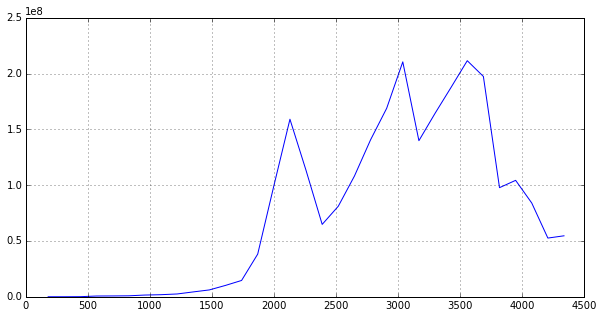

In [72]:
power1D_sobel = fft2D(sobel_sub)
plt.figure(figsize=(10, 5))
plt.plot(k[1:], power1D_sobel)
plt.grid()

I'm hoping that the 2, 3 and 3.5 meter peaks are cars and that means we can classify vehicles by size.